In [1]:
from argparse import ArgumentParser
import logging

from einops import rearrange
from matplotlib import pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
import torch
import torch.optim as optim

from src.blocks import UNet
from src.score_matching_rand import ScoreMatchingModel, ScoreMatchingModelConfig

import torchvision.transforms as transforms
import torch.utils.data as data_utils
from torchvision import datasets
from torchvision.transforms import Resize, InterpolationMode
import ssl

In [2]:
iterations = 2000
batch_size = 256
device = 'cuda'
load_trained = 1

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Load data from https://www.openml.org/d/554
# (70000, 784) values between 0-255

ssl._create_default_https_context = ssl._create_unverified_context

import torch.utils.data as data_utils

# Select training_set and testing_set
transform =  transforms.Compose([transforms.Resize(32), transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])


test_loader = datasets.MNIST("data", 
                                train= False,
                                download=True,
                                transform=transform)

test_loader = torch.utils.data.DataLoader(test_loader, batch_size=10000, shuffle=True, num_workers=0)

x = next(iter(test_loader))[0]
x = x.view(-1,32*32).numpy()

nn_module = UNet(1, 128, (1, 2, 4, 8))
model = ScoreMatchingModel(
    nn_module=nn_module,
    input_shape=(1, 32, 32,),
    config=ScoreMatchingModelConfig(
        sigma_min=0.002,
        sigma_max=80.0,
        sigma_data=1.0,
    ),
)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, iterations)

if load_trained:
    model.load_state_dict(torch.load("./ckpts/mnist_trained.pt",map_location=torch.device(device)))
else:
    for step_num in range(iterations):
        x_batch = x[np.random.choice(len(x), batch_size)]
        x_batch = torch.from_numpy(x_batch).to(device)
        x_batch = rearrange(x_batch, "b (h w) -> b () h w", h=32, w=32)
        optimizer.zero_grad()
        loss = model.loss(x_batch).mean()
        loss.backward()
        optimizer.step()
        scheduler.step()
        if step_num % 100 == 0:
            logger.info(f"Iter: {step_num}\t" + f"Loss: {loss.data:.2f}\t")
    torch.save(model.state_dict(), "./ckpts/mnist_trained.pt")

model.eval()

input_sd = 127
input_mean = 127
x_vis = x[:32] * input_sd + input_mean

# Degraded images
x_true = x[:32].reshape(32, 1, 32, 32).copy()

# Downscale and upscale functions
def downscale(image, factor):
    # Convert numpy image to tensor
    image = torch.tensor(image).unsqueeze(0)  # Add batch dimension
    downscale_transform = Resize((32 // factor, 32 // factor), interpolation=InterpolationMode.BILINEAR)
    downscaled_image = downscale_transform(image)
    return downscaled_image.squeeze(0).numpy()  # Remove batch dimension

def upscale(image, factor):
    # Convert numpy image to tensor
    image = torch.tensor(image).unsqueeze(0)  # Add batch dimension
    upscale_transform = Resize((32, 32), interpolation=InterpolationMode.BILINEAR)
    upscaled_image = upscale_transform(image)
    return upscaled_image.squeeze(0).numpy()  # Remove batch dimension

# Task 1: Upscaling
downscale_factor = 2
x_downscaled = np.array([downscale(im, downscale_factor) for im in x_true])
x_upscaled = np.array([upscale(im, downscale_factor) for im in x_downscaled])

# Task 2: Inpainting
mask_quarter = np.ones_like(x_true)
mask_quarter[:, :, :16, :16] = 0  # Missing top-left quarter
x_inpainted_quarter = x_true * mask_quarter

mask_half = np.ones_like(x_true)
mask_half[:, :, :16, :] = 0  # Missing top half
x_inpainted_half = x_true * mask_half

num_sampling_timesteps
21
tensor([1.0000, 0.9524, 0.9048, 0.8571, 0.8095, 0.7619, 0.7143, 0.6667, 0.6190,
        0.5714, 0.5238, 0.4762, 0.4286, 0.3810, 0.3333, 0.2857, 0.2381, 0.1905,
        0.1429, 0.0952, 0.0476, 0.0000], device='cuda:0')
tensor(79.9996, device='cuda:0')
0
tensor(79.9996, device='cuda:0')
1
tensor(11.5173, device='cuda:0')
2
tensor(6.1684, device='cuda:0')
3
tensor(4.1799, device='cuda:0')
4
tensor(3.1333, device='cuda:0')
5
tensor(2.4817, device='cuda:0')
6
tensor(2.0329, device='cuda:0')
7
tensor(1.7018, device='cuda:0')
8
tensor(1.4450, device='cuda:0')
9
tensor(1.2379, device='cuda:0')
10
tensor(1.0657, device='cuda:0')
11
tensor(0.9188, device='cuda:0')
12
tensor(0.7906, device='cuda:0')
13
tensor(0.6766, device='cuda:0')
14
tensor(0.5736, device='cuda:0')
15
tensor(0.4789, device='cuda:0')
16
tensor(0.3908, device='cuda:0')
17
tensor(0.3076, device='cuda:0')
18
tensor(0.2282, device='cuda:0')
19
tensor(0.1514, device='cuda:0')
20
tensor(0.0763, device='cuda:

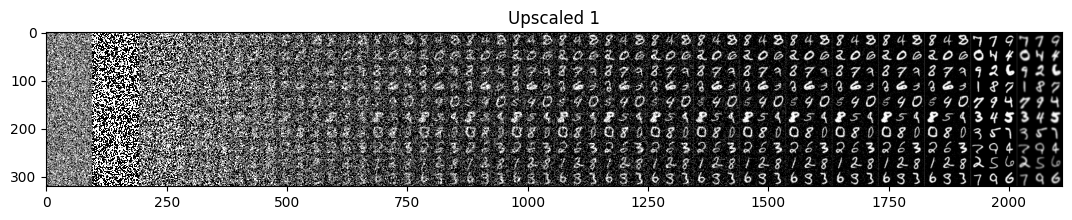

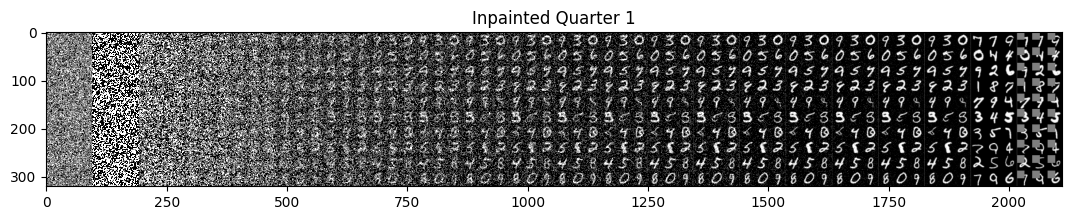

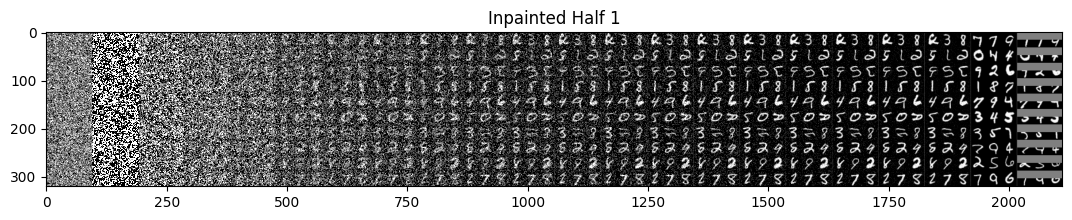

In [3]:
# Sample generation
for degraded_images, noise, description in [
    (x_upscaled, 1,"Upscaled"),
    (x_inpainted_quarter, 1, "Inpainted Quarter"),
    (x_inpainted_half, 1, "Inpainted Half")
    ]:
    samples = model.sample(bsz=32, noise=noise, x0=degraded_images, device=device).cpu().numpy()
    samples = rearrange(samples, "t b () h w -> t b (h w)")
    samples = samples * input_sd + input_mean

    nrows, ncols = 10, 3
    percents = min(len(samples),20)

    raster = np.zeros((nrows * 32, ncols * 32 * (percents + 2)), dtype=np.float32)

    degraded_images = degraded_images * input_sd + input_mean        

    # blocks of resulting images. Last row is the degraded image, before last row: the noise-free images. 
    # First rows show the denoising progression
    for percent_idx in range(percents):
        itr_num = int(round(percent_idx / (percents-1) * (len(samples)-1)))
        print(itr_num)
        for i in range(nrows * ncols):
            row, col = i // ncols, i % ncols
            offset = 32 * ncols * (percent_idx)
            raster[32 * row : 32 * (row + 1), offset + 32 * col : offset + 32 * (col + 1)] = samples[itr_num][i].reshape(32, 32)

    # last block of nrow,ncol of input images
    for i in range(nrows * ncols):
        offset = 32 * ncols * percents
        row, col = i // ncols, i % ncols
        raster[32 * row : 32 * (row + 1), offset + 32 * col : offset + 32 * (col + 1)] = x_vis[i].reshape(32, 32)

    for i in range(nrows * ncols):
        offset =  32 * ncols * (percents+1)
        row, col = i // ncols, i % ncols
        raster[32 * row : 32 * (row + 1), offset + 32 * col : offset + 32 * (col + 1)] = degraded_images[i].reshape(32, 32)

    raster[:,::32*3] = 64

    plt.figure(figsize = (20,2))
    plt.imshow(raster, vmin=0, vmax=255, cmap='gray')
    plt.title(f"{description} {noise}")


In [19]:
import src.score_matching_rand as score_matching_rand
from src.score_matching import ScoreMatchingModel, ScoreMatchingModelConfig



transform =  transforms.Compose([transforms.Resize(32), transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])


test_loader = datasets.MNIST("data", 
                                train= False,
                                download=True,
                                transform=transform)

test_loader = torch.utils.data.DataLoader(test_loader, batch_size=10000, shuffle=True, num_workers=0)

x = next(iter(test_loader))[0]
x = x.view(-1,32*32).numpy()

nn_module = UNet(1, 128, (1, 2, 4, 8))
deterministic_model = ScoreMatchingModel(
    nn_module=nn_module,
    input_shape=(1, 32, 32,),
    config=ScoreMatchingModelConfig(
        sigma_min=0.002,
        sigma_max=80.0,
        sigma_data=1.0,
    ),
)
deterministic_model = deterministic_model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, iterations)

deterministic_model.load_state_dict(torch.load("./ckpts/mnist_trained.pt",map_location=torch.device(device)))

deterministic_model.eval()

probabilistic_model = score_matching_rand.ScoreMatchingModel(
    nn_module=nn_module,
    input_shape=(1, 32, 32,),
    config=score_matching_rand.ScoreMatchingModelConfig(
        sigma_min=0.002,
        sigma_max=80.0,
        sigma_data=1.0,
    ),
)
probabilistic_model = probabilistic_model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, iterations)

probabilistic_model.load_state_dict(torch.load("./ckpts/mnist_trained.pt",map_location=torch.device(device)))

probabilistic_model.eval()


input_sd = 127
input_mean = 127
x_vis = x[:32] * input_sd + input_mean

# Degraded images
x_true = x[:32].reshape(32, 1, 32, 32).copy()



In [21]:
mask_half = np.zeros_like(x_true)
degraded_images = x_true * mask_half

In [74]:
import numpy as np
import scipy.stats
import torch

input_sd = 127
input_mean = 127

# Define a function to compute moments
def compute_moments(images):
    mean = np.mean(images, axis=(0, 2, 3))
    variance = np.var(images, axis=(0, 2, 3))
    return mean, variance

# Load your models and data
# Assume deterministic_model and probabilistic_model are instances of your model class

# Generate samples
deterministic_samples = deterministic_model.sample(bsz=32, device='cuda', noise=1.0, x0=degraded_images)

deterministic_samples = rearrange(deterministic_samples, "t b () h w -> t b (h w)")
deterministic_samples = deterministic_samples * input_sd + input_mean
deterministic_samples = deterministic_samples[-3].reshape(x_true.shape)

probabilistic_samples = probabilistic_model.sample(bsz=32, device='cuda', noise=1.0, x0=degraded_images)
probabilistic_samples = rearrange(probabilistic_samples, "t b () h w -> t b (h w)")
probabilistic_samples = probabilistic_samples * input_sd + input_mean
probabilistic_samples = probabilistic_samples[-3].reshape(x_true.shape)


# Convert samples to numpy arrays
deterministic_samples_np = deterministic_samples.cpu().numpy()
probabilistic_samples_np = probabilistic_samples.cpu().numpy()

# Compute moments
det_mean_det, det_variance_det = compute_moments(deterministic_samples_np)
prob_mean_prob, prob_variance_prob = compute_moments(probabilistic_samples_np)

# Load true images
# This depends on your data loading logic
true_images = x_true
true_images_np = true_images

# Compute moments for true images
true_mean, true_variance = compute_moments(true_images_np)

# Compare moments
def compare_moments(true_moments, generated_moments):
    true_mean, true_variance = true_moments
    gen_mean, gen_variance = generated_moments
    mean_diff = np.abs(true_mean - gen_mean)
    variance_diff = np.abs(true_variance - gen_variance)
    return mean_diff, variance_diff

# Compute differences
det_moments = (det_mean_det, det_variance_det)
prob_moments = (prob_mean_prob, prob_variance_prob)

det_diff = compare_moments((true_mean, true_variance), det_moments)
prob_diff = compare_moments((true_mean, true_variance), prob_moments)

print("Differences for deterministic samples:", det_diff)
print("Differences for probabilistic samples:", prob_diff)


num_sampling_timesteps
21
tensor([1.0000, 0.9524, 0.9048, 0.8571, 0.8095, 0.7619, 0.7143, 0.6667, 0.6190,
        0.5714, 0.5238, 0.4762, 0.4286, 0.3810, 0.3333, 0.2857, 0.2381, 0.1905,
        0.1429, 0.0952, 0.0476, 0.0000], device='cuda:0')
tensor(79.9996, device='cuda:0')
0
tensor(79.9996, device='cuda:0')
1
tensor(11.5173, device='cuda:0')
2
tensor(6.1684, device='cuda:0')
3
tensor(4.1799, device='cuda:0')
4
tensor(3.1333, device='cuda:0')
5
tensor(2.4817, device='cuda:0')
6
tensor(2.0329, device='cuda:0')
7
tensor(1.7018, device='cuda:0')
8
tensor(1.4450, device='cuda:0')
9
tensor(1.2379, device='cuda:0')
10
tensor(1.0657, device='cuda:0')
11
tensor(0.9188, device='cuda:0')
12
tensor(0.7906, device='cuda:0')
13
tensor(0.6766, device='cuda:0')
14
tensor(0.5736, device='cuda:0')
15
tensor(0.4789, device='cuda:0')
16
tensor(0.3908, device='cuda:0')
17
tensor(0.3076, device='cuda:0')
18
tensor(0.2282, device='cuda:0')
19
tensor(0.1514, device='cuda:0')
20
tensor(0.0763, device='cuda:

Differences for deterministic samples: (array([34.3356], dtype=float32), array([5260.09], dtype=float32))
Differences for probabilistic samples: (array([36.111057], dtype=float32), array([5980.0273], dtype=float32))

Moments Chosen for Comparison
    Mean:
        Purpose: The mean gives the average pixel value across all images and helps assess if the overall brightness of the generated images matches the true images.
    Value Obtained:
        Deterministic Samples: Mean difference = 34.3356
        Probabilistic Samples: Mean difference = 36.1111
    Variance:
        Purpose: Variance measures the spread of pixel values and indicates the diversity or contrast in the images. It helps evaluate if the generated images have similar variability to the true images.
        Value Obtained:
            Deterministic Samples: Variance difference = 5260.09
            Probabilistic Samples: Variance difference = 5980.0273
Interpretation of Results
    Mean Difference:
        The mean difference indicates how close the average pixel value of the generated images is to the true images. Both methods show relatively large differences, but the deterministic method is slightly closer to the true mean.
    Variance Difference:
        The variance difference shows how well the spread or contrast of the generated images matches the true images. The deterministic approach has a lower variance difference compared to the probabilistic method, indicating that the deterministic method may better replicate the true image contrast.